$$\textbf{Chad Schupbach}$$

***

The default backend engine for Keras (Tensorflow) uses CUDA, an API only supported by NVIDIA GPUs. We utilize [PlaidML](https://github.com/plaidml/plaidml) as Keras backend engine, which has Metal support for the current device GPU (AMD Radeon Pro 5300M). We reassign Keras backend engine as PlaidML in the following two code blocks.

In [1]:
import os

In [2]:
path = '/Users/chadschupbach/opt/anaconda3/'
os.environ['KERAS_BACKEND'] = 'plaidml.keras.backend'
os.environ['RUNFILES_DIR'] = path + 'share/plaidml'
os.environ['PLAIDML_NATIVE_PATH'] = path + 'lib/libplaidml.dylib'

In [3]:
import numpy as np
import pandas as pd
import keras
from keras.layers import Conv2D
from keras.layers import MaxPooling2D, BatchNormalization
from keras.layers import Flatten, Dense, Dropout
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend as K
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
import time
from src import utils

Using plaidml.keras.backend backend.


# MNIST

The MNIST digits dataset is one of the most widely used datasets for high-dimensional classification. While recent advancements in deep learning have led many to conclude MNIST digits classification is a solved problem, we use it here as introduction to deep learning. Prior to these advancements, support-vector machine classification was considered to be the optimal approach to the MNIST digits problem; achieving a maximum testing accuracy around 97.8% [[Zalando Research](http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/#)]. In our next [notebook](https://github.com/cschupbach/deep_learning_cnn/blob/master/ensemble_cnn_fashion.ipynb), we dive into deep learning using the dataset released primarily as a replacement to the MNIST digits dataset. One of the reasons the MNIST digits dataset is so popular is its wide availability as part of the Keras distribution. In addition, the dataset is large enough for meaningful deep learning application, while not being so large that it requires using GPU support.

## Initialization

Load the entire MNIST digits dataset containing 60000 training images and 10000 testing images across 10 classes $\{0,1,\dots,8,9\}$.

In [4]:
x_train, y_train, x_test, y_test, input_shape = utils.load_mnist()

INFO:plaidml:Opening device "metal_amd_radeon_pro_5300m.0"


The first 12 samples from each class are shown below.

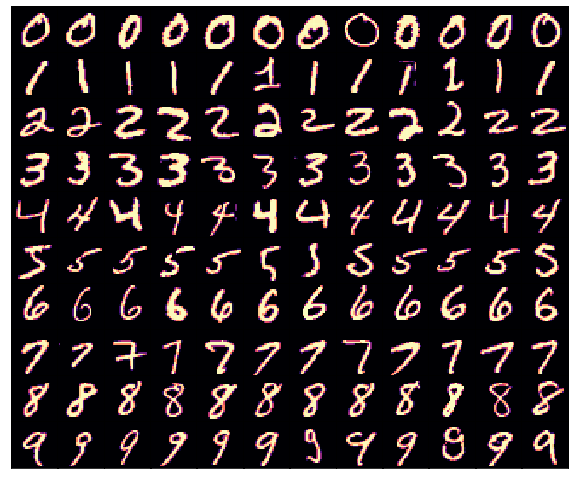

In [5]:
utils.plot_samples(x_train, y_train)

We display the mean training image for each class as follows:

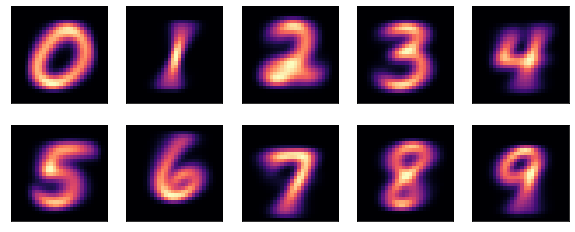

In [6]:
utils.plot_class_means(x_train, y_train)

For the ensemble, we will train 10 models with the same architecture using a batch size of 128.

In [7]:
n_classes = y_test.shape[-1]
n_models = 10
batch_size = 128

The architecture of each CNN model is as follows:

In [8]:
model = [None] * n_models
for i in range(n_models):
    model[i] = Sequential()
    model[i].add(Conv2D(16, 3, padding='same', activation='relu',
                        input_shape=(28, 28, 1)))
    model[i].add(Conv2D(16, 3, padding='same', activation='relu'))
    model[i].add(MaxPooling2D(pool_size=(2, 2)))
    model[i].add(Conv2D(32, 3, padding='same', activation='relu'))
    model[i].add(Conv2D(32, 3, padding='same', activation='relu'))
    model[i].add(MaxPooling2D(pool_size=(2, 2)))
    model[i].add(Conv2D(64, 3, padding='same', activation='relu'))
    model[i].add(Conv2D(64, 3, padding='same', activation='relu'))
    model[i].add(Conv2D(64, 3, activation='relu'))
    model[i].add(Flatten())
    model[i].add(Dropout(0.25))
    model[i].add(Dense(batch_size, activation='relu'))
    model[i].add(Dropout(0.5))
    model[i].add(Dense(batch_size, activation='relu'))
    model[i].add(Dropout(0.5))
    model[i].add(Dense(n_classes, activation='softmax'))
    model[i].compile(optimizer='nadam', loss='categorical_crossentropy',
                     metrics=['accuracy'])

In [9]:
model[0].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 64)          18496     
__________

We assign model checkpoints and early stopping criterion below. The checkpoints save parameter weights of the best training epoch based on validation accuracy to files in the `models/mnist/` directory. We also set early stopping criterion indicating convergence when no decrease in validation loss is observed over 7 epochs.

In [10]:
checkpoint = []
earlystop = []
for i in range(n_models):
    checkpoint += [ModelCheckpoint(filepath=f'models/mnist/best_weights_{i}.hdf5',
                                   monitor='val_acc', save_best_only=True,
                                   save_weights_only=True, mode='max')]
    earlystop += [EarlyStopping(monitor='val_loss', patience=10, mode='min')]

If the early stopping criterion is not met, we end the training session of each model after 20 epochs. Because we need a validation set for the checkpoints and convergence criterion, we generate seeds (cell 11) to randomly split the training data into 50000 training samples and 10000 validation samples prior to each training session. It's not uncommon to see similar models implemented using the testing set for model validation in an effort to fully utilize the available training data. While it's tempting given that the validation set is not actually being used in training, using this strategy will result in model selection bias and should be avoided.

We fit each CNN model as follows:

In [11]:
start = time.time()
epochs = 25
ledger = []
for i in range(n_models):
    clear_output(wait=True)
    print(f'CNN_{i+1}\n' + '='*50)
    x, x_valid, y, y_valid = train_test_split(x_train, y_train,
                                              test_size=0.2)
    ledger += [model[i].fit(x, y, batch_size=batch_size, epochs=epochs,
                            verbose=1, callbacks=[checkpoint[i], earlystop[i]],
                            validation_data=(x_valid, y_valid))]
runtime = time.time() - start

CNN_10
Train on 48000 samples, validate on 12000 samples
Epoch 1/25
48000/48000 [==============================] - 30s 620us/step - loss: 0.3939 - acc: 0.8768 - val_loss: 0.0728 - val_acc: 0.9778
Epoch 2/25
48000/48000 [==============================] - 29s 599us/step - loss: 0.0986 - acc: 0.9743 - val_loss: 0.0596 - val_acc: 0.9830
Epoch 3/25
48000/48000 [==============================] - 28s 590us/step - loss: 0.0705 - acc: 0.9824 - val_loss: 0.0361 - val_acc: 0.9901
Epoch 4/25
48000/48000 [==============================] - 28s 581us/step - loss: 0.0558 - acc: 0.9868 - val_loss: 0.0395 - val_acc: 0.9902
Epoch 5/25
48000/48000 [==============================] - 28s 593us/step - loss: 0.0497 - acc: 0.9878 - val_loss: 0.0324 - val_acc: 0.9901
Epoch 6/25
48000/48000 [==============================] - 28s 583us/step - loss: 0.0448 - acc: 0.9889 - val_loss: 0.0340 - val_acc: 0.9908
Epoch 7/25
48000/48000 [==============================] - 28s 590us/step - loss: 0.0430 - acc: 0.9891 - val_l

In [12]:
print('Total runtime: {:.2f} min'.format(runtime / 60))

Total runtime: 89.47 min


The training epochs of the final model are shown as output to cell 12. In addition, we observe a total runtime of just over 104 minutes for fitting all models. The training summary is given below.

In [13]:
utils.training_summary(model, ledger, x_test, y_test)

,Epoch,Train Loss,Val Loss,Test Loss,Train Acc,Val Acc,Test Acc
Model 0,13.0,0.02312,0.02649,0.02495,0.9940,0.9928,0.9929
Model 1,8.0,0.02541,0.03890,0.02766,0.9935,0.9913,0.9933
Model 2,12.0,0.02622,0.03092,0.03552,0.9935,0.9938,0.9936
Model 3,10.0,0.02255,0.03681,0.03107,0.9945,0.9927,0.9932
Model 4,18.0,0.02302,0.03408,0.03520,0.9944,0.9919,0.9911
Model 5,10.0,0.02223,0.03345,0.02998,0.9946,0.9912,0.9922
Model 6,9.0,0.02388,0.03516,0.03655,0.9940,0.9920,0.9916
Model 7,16.0,0.02556,0.02858,0.03413,0.9937,0.9922,0.9930
Model 8,12.0,0.02686,0.02962,0.03484,0.9928,0.9924,0.9924
Model 9,13.0,0.02298,0.03035,0.02710,0.9943,0.9926,0.9933


Taking a look at the average of all models above, we observe a mean training, validation, and testing accuracies of 94.08%, 92.37%, and 91.63%, respectively. The small decrease in testing accuracy relative to validation accuracy reveals a small amount of overfitting not accounted for by the three dropout layers. It's plausible that reducing model complexity with the addition of an L1 regularizer might help account for a fraction of the overfitting. We combine the results of all models to form the ensemble CNN as follows:

In [14]:
test_act, test_pred, test_res = utils.ensemble_results(model, x_train, y_train,
                                                       x_test, y_test)

Ensemble Train Accuracy: 0.9989
Ensemble Test Accuracy: 0.9962


Shown above, the ensemble CNN results in a testing accuracy of 93.43%. We observe increases in testing accuracy of 1.80% and 1.49% relative to the average testing accuracy across all models (91.63%) and the model with the best testing accuracy (Model 4, 91.94%), respectively. We display the confusion matrix for the ensemble as follows:

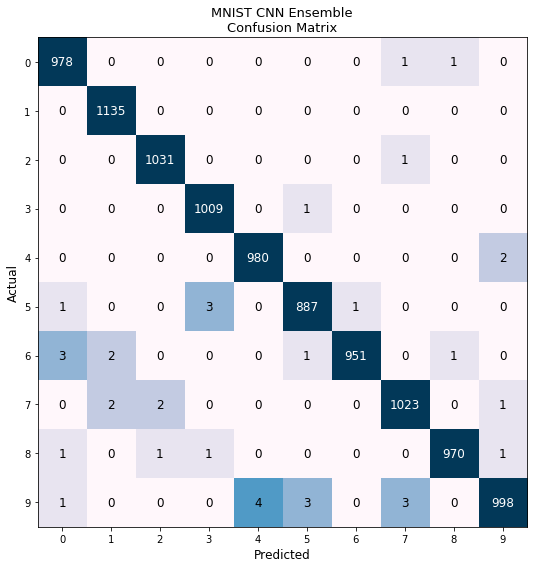

In [15]:
utils.plot_confusion(test_act, test_pred)

The confusion matrix above reveals poor performance of the model when classifying shirts, where items labelled `Shirt` are frequently misclassified as `T-shirt`, and vice versa. We also observe items labelled `Shirt` misclassified as `Pullover` and `Coat` at a relatively high rate. Some other item pairs that are difficult for the model to tell apart are `Sneaker`/`Boot` and `Coat`/`Pullover`. Below, we display the first 50 misclassified fashion items from the testing data with their respective actual and predicted labels. For each label, we also display the probability that the label is true according to the trained ensemble. Doing this provides some insight into how close the CNN ensemble was to predicting the labels of misclassified items correctly.

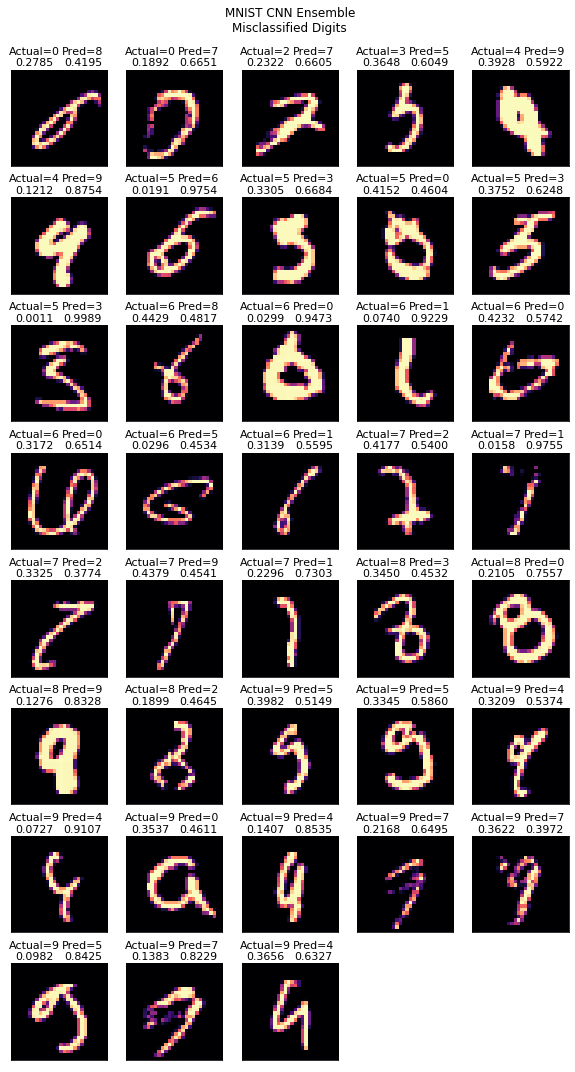

In [16]:
utils.plot_misclassified(x_test, test_pred, test_act, test_res, _sort=True)